In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def broadcast_kron(a,b):
    """broadcasted kronecker product of two N,M,...,2,2 arrays. Used for jones -> mueller conversion
    In the unbroadcasted case, this output looks like

    out = [a[0,0]*b,a[0,1]*b]
          [a[1,0]*b,a[1,1]*b]

    where out is a N,M,...,4,4 array. I wrote this to work for generally shaped kronecker products where the matrix
    is contained in the last two axes, but it's only tested for the Nx2x2 case

    Parameters
    ----------
    a : numpy.ndarray
        N,M,...,2,2 array used to scale b in kronecker product
    b : numpy.ndarray
        N,M,...,2,2 array used to form block matrices in kronecker product

    Returns
    -------
    out
        N,M,...,4,4 array
    """

    return np.einsum('...ik,...jl',a,b).reshape([*a.shape[:-2],int(a.shape[-2]*b.shape[-2]),int(a.shape[-1]*b.shape[-1])])

def jones_to_mueller(jones):
    """Construct a Mueller Matrix given a Jones Matrix. From Chipman, Lam, and Young Eq (6.99).

    Parameters
    ----------
    jones : ndarray with final dimensions 2x2
        The complex-valued jones matrices to convert into mueller matrices

    Returns
    -------
    M : np.ndarray
        Mueller matrix
    """

    U = np.array([[1,0,0,1],
                  [1,0,0,-1],
                  [0,1,1,0],
                  [0,1j,-1j,0]])/np.sqrt(2)
    
    if jones.ndim == 2:
        jprod = np.kron(np.conj(jones),jones)
    else:
        # broadcasted kronecker product with einsum
        jprod = broadcast_kron(np.conj(jones),jones)
    M = np.real(U @ jprod @ np.linalg.inv(U))

    return M

In [4]:
psf = np.load('nominal_psfs/ELT_order2_Iband_segvar.npy')
psf.shape

(2, 2, 22500)

## Polarizance Vector for GSMTs

(150, 150, 2, 2)
(150, 150, 2, 2)
(150, 150, 2, 2)


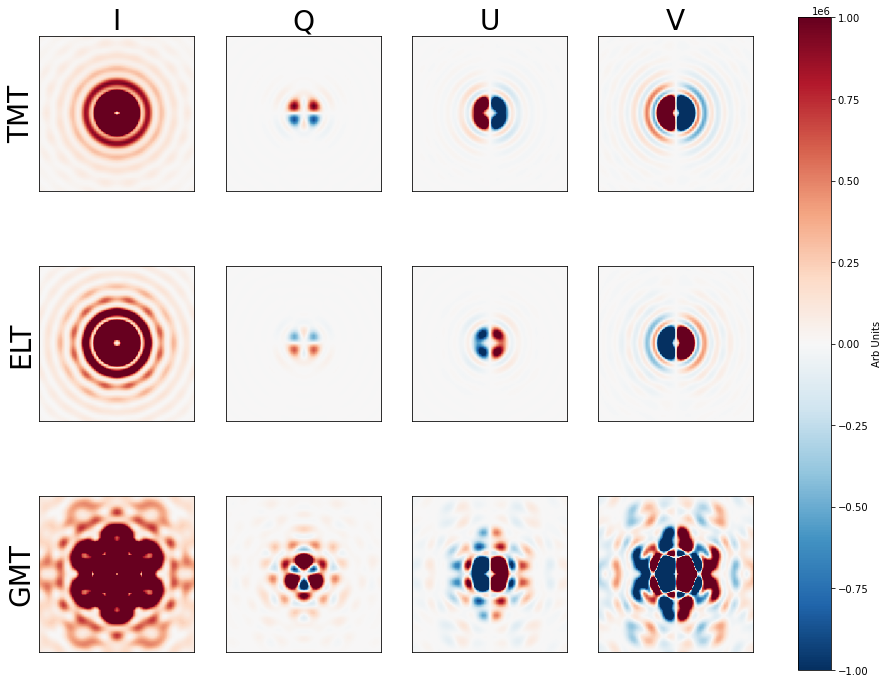

In [31]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

scope = ['TMT','ELT','GMT']
stokes = ['I','Q','U','V']
order = 2

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=[16,12])

cut = 32
for i, tele in enumerate(scope):
    pth = 'nominal_psfs/'+tele+f'_order{order}_Iband_segvar.npy'
    dat = np.load(pth).reshape([2,2,150,150])
    dat = np.moveaxis(np.moveaxis(dat,0,-1), 0,-1)
    print(dat.shape)

    # convert to a Mueller matrix
    mul = jones_to_mueller(dat)

    # get the stokes vector
    svec_data = mul[...,:,0]

    for j, s in enumerate(stokes):

        im = axs[i, j].imshow(svec_data[...,j], cmap='RdBu_r', vmax=1e6, vmin=-1e6)
        axs[i, j].set_xticks([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xlim(150/2-cut,150/2+cut)
        axs[i, j].set_ylim(150/2-cut,150/2+cut)

        # div = make_axes_locatable(axs[i, j])
        # cax = div.append_axes("right", size="7%", pad="2%")
        # fig.colorbar(im, cax=cax)

        axs[i, j].set_xticks([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_yticklabels([])

        if i == 0:
            axs[i, j].set_title(s, fontsize=28)

        if j == 0:
            axs[i, j].set_ylabel(tele, fontsize=28)
fig.colorbar(im, ax=axs, label='Arb Units')
plt.show()